### GPU CHECKS AND IMPORTING DATA

All work was done in AWS, so google colab related code is removed as well as downloading of N-HPatches etc.

In [0]:
%cd keras_triplet_descriptor

!pip install humanize
!pip install talos
!pip install sklearn
!pip install opencv-python
import psutil
import humanize
import os

import sys
import json
import os
import glob
import time
import tensorflow as tf
import numpy as np
import cv2
import random
import talos
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, Conv3D, MaxPooling2D, BatchNormalization 
from keras.layers import Input, UpSampling2D, concatenate  
from keras.activations import sigmoid, relu, elu
from talos import live, Reporting
from talos.model.normalizers import lr_normalizer
from keras.losses import mean_squared_error, binary_crossentropy
from keras.optimizers import Adam, Nadam, SGD
from sklearn.preprocessing import MinMaxScaler

K.set_floatx('float16')  
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)   

#!wget -O hpatches_data.zip https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
  
#!unzip -q ./hpatches_data.zip
#!rm ./hpatches_data.zip

hpatches_dir = './hpatches'
splits_path = './splits.json'

splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']

train_fnames = split['train']
test_fnames = split['test']

seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]   
seqs_train = list(filter(lambda x: x.split('/')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('/')[-1] in split['test'], seqs))

from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet

### OPTIMISING THE HYPERPARAMETERS OF THE DENOISING SYSTEM

Extracting small sample of the data from the generators, because no keras hyperparameter optimisation libraries support generators.

In [0]:
denoise_generator_talos = DenoiseHPatches(random.sample(seqs_train, 3), batch_size=500)
denoise_generator_val_talos = DenoiseHPatches(random.sample(seqs_test, 1), batch_size=500)

xTrain, yTrain = denoise_generator_talos.__getitem__(0)
xVal, yVal = denoise_generator_val_talos.__getitem__(0)

100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Model definition with all the hyperparametrs we will test.

In [0]:
def talosDenoiseOptimisation(xTrain, yTrain, xVal, yVal, params):
  
  inputs = Input((32, 32, 1))
  
  conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  drop4 = Dropout(rate=params['dropout'])(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  drop5 = Dropout(rate = params['dropout'])(conv5)
  
  up6 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)

  up7 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)

  up8 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)

  up9 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv10 = Conv2D(1, 3,  padding = 'same')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  
  model.compile(loss = params['losses'],
                optimizer=params['optimizer'](lr=lr_normalizer(params['lr'],params['optimizer'])),
                metrics = ['mae']) 
  
  out = model.fit(x = xTrain, y = yTrain,
                   epochs = params['epochs'],
                   verbose=0,
                   validation_data = [xVal, yVal],
                   batch_size = params['batch_size'])
  
  return out, model

Experiment 1. Custom loss functions defined and all the exact hyperparameters that will be searched.

In [0]:
def PSNRInverse(yTrue, yPred): return 1.0/(10.0 * K.log(65025.0/mean_squared_error(yTrue, yPred)))
def customBCE(yTrue, yPred): return binary_crossentropy(yTrue / 255.0, yPred / 255.0)
def customSGD(lr): return SGD(lr=lr, momentum=0.9, nesterov=True)

param = {
    'losses' : ['mean_absolute_error', PSNRInverse, 'logcosh'],
    'optimizer' : [Adam, Nadam, customSGD],
    'epochs' : [5],
    'lr' : (0.00001, 0.5, 20),
    'batch_size' : (5 , 300, 10),
    'dropout' : (0, 0.99, 15)}


r = talos.Scan(x = xTrain, y = yTrain,
           params = param,
           model = talosDenoiseOptimisation,
           grid_downsample = 0.01,
           dataset_name = 'NHPatches_Denoise',
           experiment_no = '1',
           x_val = xVal, y_val = yVal,
           disable_progress_bar = False)

100%|██████████| 297/297 [15:52<00:00,  2.62s/it]


Observing the top performing models for experiment 1.

In [0]:
r = Reporting('NHPatches_Denoise_1.csv')

Exp1Data = r.data
Exp1Data = Exp1Data.drop(Exp1Data[Exp1Data.val_mean_absolute_error > 15].index)
Exp1Data = Exp1Data.drop(columns=['loss', 'val_loss', 'round_epochs', 'epochs'])
Exp1Data = Exp1Data.dropna()

%matplotlib inline

Exp1Data

val_mean_absolute_error  mean_absolute_error  \
30                 14.206613            17.576447   
33                 10.529248            11.473592   
51                  9.136231            10.319978   
79                  6.116759             6.880806   
85                 14.846262            16.999010   
108                10.403484            11.751162   
113                11.416707            12.670494   
114                 7.572564            10.447390   
118                11.472585            13.562429   
126                 6.611448             7.303565   
131                 9.250156            10.232699   
133                12.216202            15.251948   
143                 9.119672            10.796815   
153                10.092435            11.224336   
159                10.248141            12.652691   
173                 9.828588            12.348095   
177                10.400679            10.609643   
178                12.555597            14.464185   
181                 8.613395             9.256106   
184                11.438382            11.890030   
186                 9.008848            10.994173   
202                 7.954382             8.878359   
208                13.113439            14.378060   
241                 7.112666             7.988075   
248                 6.948719             7.621632   
252                11.906746            13.173577   
255                 9.381301            10.400868   
262                14.163370            17.254494   
264                10.354514            12.051863   
267                 7.068252             7.663052   
274                 6.499433             7.965312   
282                14.586692            16.636873   

                                  optimizer  dropout               losses  \
30         <class 'keras.optimizers.Nadam'>    0.924              logcosh   
33   <function customSGD at 0x7fd0c1c7c8c0>    0.396  mean_absolute_error   
51          <class 'keras.optimizers.Adam'>    0.594              logcosh   
79          <class 'keras.optimizers.Adam'>    0.792              logcosh   
85          <class 'keras.optimizers.Adam'>    0.528  mean_absolute_error   
108         <class 'keras.optimizers.Adam'>    0.792  mean_absolute_error   
113        <class 'keras.optimizers.Nadam'>    0.660  mean_absolute_error   
114        <class 'keras.optimizers.Nadam'>    0.792              logcosh   
118  <function customSGD at 0x7fd0c1c7c8c0>    0.330              logcosh   
126        <class 'keras.optimizers.Nadam'>    0.726  mean_absolute_error   
131         <class 'keras.optimizers.Adam'>    0.660              logcosh   
133        <class 'keras.optimizers.Nadam'>    0.066              logcosh   
143        <class 'keras.optimizers.Nadam'>    0.528              logcosh   
153         <class 'keras.optimizers.Adam'>    0.396  mean_absolute_error   
159        <class 'keras.optimizers.Nadam'>    0.396              logcosh   
173        <class 'keras.optimizers.Nadam'>    0.858  mean_absolute_error   
177        <class 'keras.optimizers.Nadam'>    0.000              logcosh   
178        <class 'keras.optimizers.Nadam'>    0.594  mean_absolute_error   
181         <class 'keras.optimizers.Adam'>    0.924  mean_absolute_error   
184        <class 'keras.optimizers.Nadam'>    0.726  mean_absolute_error   
186        <class 'keras.optimizers.Nadam'>    0.792  mean_absolute_error   
202         <class 'keras.optimizers.Adam'>    0.528              logcosh   
208         <class 'keras.optimizers.Adam'>    0.396  mean_absolute_error   
241        <class 'keras.optimizers.Nadam'>    0.132  mean_absolute_error   
248         <class 'keras.optimizers.Adam'>    0.858              logcosh   
252         <class 'keras.optimizers.Adam'>    0.462  mean_absolute_error   
255         <class 'keras.optimizers.Adam'>    0.066              logcosh   
262        <class 'keras.optimizers.Nadam'>    0.594  mean_absolute_error   
264        <class 'ker

Visualising a correlation heatmap to get a better understanding of what is affecting the test loss.

In [0]:
#https://stackoverflow.com/questions/12286607/making-heatmap-from-pandas-dataframe

import seaborn as sns

Exp1Data = r.data
Exp1Data = Exp1Data.drop(Exp1Data[Exp1Data.val_mean_absolute_error > 100].index)
Exp1Data = Exp1Data.dropna()
Exp1Data = Exp1Data.drop(columns=['loss', 'val_loss', 'round_epochs', 'epochs'])


column_names_to_normalize = ['val_mean_absolute_error', 'mean_absolute_error', 'batch_size', 'lr', 'dropout']
x = Exp1Data[column_names_to_normalize].values
x_scaled = MinMaxScaler().fit_transform(x)
df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = Exp1Data.index)
Exp1Data[column_names_to_normalize] = df_temp

corr = Exp1Data.corr()

cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

Experiment 2. Exhaustive search of the best dropout.

In [0]:
param = {
    'losses' : ['mean_absolute_error'],
    'optimizer' : [Adam],
    'epochs' : [5],
    'lr' : [0.01],
    'batch_size' : [25],
    'dropout' : (0.0, 1.0, 250)}


r = talos.Scan(x = xTrain, y = yTrain,
           params = param,
           model = talosDenoiseOptimisation,
           grid_downsample = 1,
           dataset_name = 'NHPatches_Denoise',
           experiment_no = '2',
           x_val = xVal, y_val = yVal,
           disable_progress_bar = False)






  0%|          | 0/250 [00:00<?, ?it/s]




  0%|          | 1/250 [00:04<16:47,  4.05s/it]




  1%|          | 2/250 [00:07<16:15,  3.93s/it]




  1%|          | 3/250 [00:11<15:50,  3.85s/it]




  2%|▏         | 4/250 [00:14<15:17,  3.73s/it]




  2%|▏         | 5/250 [00:18<15:15,  3.74s/it]




  2%|▏         | 6/250 [00:22<15:17,  3.76s/it]




  3%|▎         | 7/250 [00:25<14:46,  3.65s/it]




  3%|▎         | 8/250 [00:29<14:55,  3.70s/it]




  4%|▎         | 9/250 [00:33<14:32,  3.62s/it]




  4%|▍         | 10/250 [00:36<14:45,  3.69s/it]




  4%|▍         | 11/250 [00:40<14:51,  3.73s/it]




  5%|▍         | 12/250 [00:44<14:27,  3.64s/it]




  5%|▌         | 13/250 [00:48<14:41,  3.72s/it]




  6%|▌         | 14/250 [00:51<14:46,  3.75s/it]




  6%|▌         | 15/250 [00:55<14:21,  3.67s/it]




  6%|▋         | 16/250 [00:59<14:30,  3.72s/it]




  7%|▋         | 17/250 [01:02<14:05,  3.63s/it]




  7%|▋         | 18/250 [01:06<14:17,  3.70s/it]




  8%|▊

 95%|█████████▌| 238/250 [14:40<00:44,  3.68s/it]




 96%|█████████▌| 239/250 [14:44<00:41,  3.75s/it]




 96%|█████████▌| 240/250 [14:48<00:37,  3.77s/it]




 96%|█████████▋| 241/250 [14:51<00:32,  3.66s/it]




 97%|█████████▋| 242/250 [14:55<00:29,  3.75s/it]




 97%|█████████▋| 243/250 [14:59<00:25,  3.65s/it]




 98%|█████████▊| 244/250 [15:02<00:22,  3.72s/it]




 98%|█████████▊| 245/250 [15:06<00:18,  3.74s/it]




 98%|█████████▊| 246/250 [15:10<00:14,  3.64s/it]




 99%|█████████▉| 247/250 [15:13<00:11,  3.70s/it]




 99%|█████████▉| 248/250 [15:17<00:07,  3.73s/it]




100%|█████████▉| 249/250 [15:21<00:03,  3.64s/it]




100%|██████████| 250/250 [15:25<00:00,  3.70s/it]

Visualising the effect of dropout on the network.

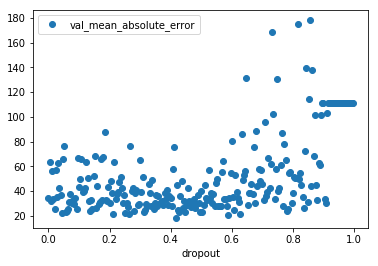

In [0]:
r = Reporting('NHPatches_Denoise_2.csv')

Exp2Data = r.data
Exp2Data = Exp2Data.drop(columns=['loss', 'val_loss', 'round_epochs', 'epochs', 'batch_size', 'lr'])
Exp2Data = Exp2Data.drop(Exp2Data[Exp2Data.val_mean_absolute_error > 1000].index)
Exp2Data = Exp2Data.dropna()

Exp2Data.plot(x='dropout', y='val_mean_absolute_error', style='o')

Experiment 3. Exhaustive search of the learning rate.

In [0]:
param = {
    'losses' : ['mean_absolute_error'],
    'epochs' : [10],
    'lr' : (0.0001, 1.0, 250),
    'batch_size' : [25],
    'dropout' : [0.4]}

def talosDenoiseOptimisation(xTrain, yTrain, xVal, yVal, params):
  
  inputs = Input((32, 32, 1))
  
  conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  drop4 = Dropout(rate=params['dropout'])(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  drop5 = Dropout(rate = params['dropout'])(conv5)
  
  up6 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)

  up7 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)

  up8 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)

  up9 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv10 = Conv2D(1, 3,  padding = 'same')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  
  model.compile(loss = params['losses'],
                optimizer= Adam(lr = params['lr']),
                metrics = ['mae']) 
  
  out = model.fit(x = xTrain, y = yTrain,
                   epochs = params['epochs'],
                   verbose=0,
                   validation_data = [xVal, yVal],
                   batch_size = params['batch_size'])
  
  return out, model

r = talos.Scan(x = xTrain, y = yTrain,
           params = param,
           model = talosDenoiseOptimisation,
           grid_downsample = 1,
           dataset_name = 'NHPatches_Denoise',
           experiment_no = '3',
           x_val = xVal, y_val = yVal,
           disable_progress_bar = False)








  0%|          | 0/250 [00:00<?, ?it/s]






  0%|          | 1/250 [00:05<24:34,  5.92s/it]






  1%|          | 2/250 [00:10<23:13,  5.62s/it]






  1%|          | 3/250 [00:15<22:20,  5.43s/it]






  2%|▏         | 4/250 [00:20<21:44,  5.30s/it]






  2%|▏         | 5/250 [00:25<21:14,  5.20s/it]






  2%|▏         | 6/250 [00:30<20:48,  5.12s/it]






  3%|▎         | 7/250 [00:35<20:30,  5.06s/it]






  3%|▎         | 8/250 [00:40<20:14,  5.02s/it]






  4%|▎         | 9/250 [00:45<20:23,  5.08s/it]






  4%|▍         | 10/250 [00:50<20:04,  5.02s/it]






  4%|▍         | 11/250 [00:55<20:01,  5.03s/it]






  5%|▍         | 12/250 [01:00<19:54,  5.02s/it]






  5%|▌         | 13/250 [01:05<19:55,  5.05s/it]






  6%|▌         | 14/250 [01:10<19:48,  5.04s/it]






  6%|▌         | 15/250 [01:15<19:38,  5.02s/it]






  6%|▋         | 16/250 [01:20<19:28,  4.99s/it]






  7%|▋         | 17/250 [01:25<19:21,  4.98s/it]






  7%|▋         | 18/2

 85%|████████▌ | 213/250 [17:41<03:04,  4.97s/it]






 86%|████████▌ | 214/250 [17:46<02:59,  4.99s/it]






 86%|████████▌ | 215/250 [17:51<02:54,  4.98s/it]






 86%|████████▋ | 216/250 [17:56<02:49,  4.97s/it]






 87%|████████▋ | 217/250 [18:01<02:43,  4.97s/it]






 87%|████████▋ | 218/250 [18:06<02:38,  4.97s/it]






 88%|████████▊ | 219/250 [18:11<02:34,  4.98s/it]






 88%|████████▊ | 220/250 [18:16<02:29,  4.97s/it]






 88%|████████▊ | 221/250 [18:21<02:24,  4.99s/it]






 89%|████████▉ | 222/250 [18:26<02:19,  4.99s/it]






 89%|████████▉ | 223/250 [18:31<02:14,  4.99s/it]






 90%|████████▉ | 224/250 [18:36<02:09,  4.98s/it]






 90%|█████████ | 225/250 [18:41<02:04,  4.96s/it]






 90%|█████████ | 226/250 [18:46<01:58,  4.95s/it]






 91%|█████████ | 227/250 [18:51<01:53,  4.93s/it]






 91%|█████████ | 228/250 [18:56<01:49,  4.96s/it]






 92%|█████████▏| 229/250 [19:01<01:46,  5.05s/it]






 92%|█████████▏| 230/250 [19:06<01:39,  4.99s/it

Visualising the learning rate experiment.

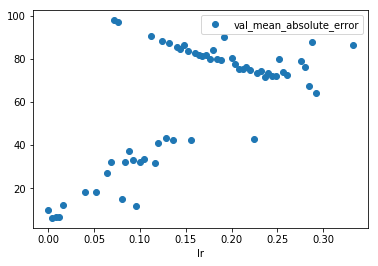

In [0]:
r = Reporting('NHPatches_Denoise_3.csv')

Exp2Data = r.data
Exp2Data = Exp2Data.drop(columns=['loss', 'val_loss', 'round_epochs', 'epochs', 'batch_size', 'dropout'])
Exp2Data = Exp2Data.drop(Exp2Data[Exp2Data.val_mean_absolute_error > 100].index)
Exp2Data = Exp2Data.dropna()


Exp2Data.plot(x='lr', y='val_mean_absolute_error', style='o')

Defenition and training of the final denoising model with optimised hyperparameters.

In [0]:
def get_denoise_model_improved():
  
  inputs = Input((32, 32, 1))
  
  conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  drop4 = Dropout(rate=0.4)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  drop5 = Dropout(rate = 0.4)(conv5)
  
  up6 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)

  up7 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)

  up8 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)

  up9 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv10 = Conv2D(1, 3,  padding = 'same')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  
  return model

get_denoise_model_improved().summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 32, 32, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 16, 16, 32)   0           conv2d_29[0][0]                  
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 16, 16, 64)   18496       max_pooling2d_9[0][0]            
__________________________________________________________________________________________________
max_poolin

In [0]:
denoise_generator = DenoiseHPatches(seqs_train, batch_size=512)
denoise_generator_val = DenoiseHPatches(seqs_test, batch_size=512)


100%|██████████| 40/40 [01:31<00:00,  1.85s/it]

In [0]:
#try: del denoise_model
#except: print("")

denoise_model = get_denoise_model_improved()

denoise_model.compile(loss='mean_absolute_error', optimizer = Adam(lr = 0.005, decay = 0.0001), metrics=['mae'])

denoise_history = denoise_model.fit_generator(generator=denoise_generator, epochs=50, verbose=1, validation_data=denoise_generator_val)

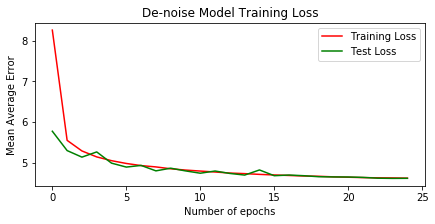

In [0]:
denoise_model.save('denoise.h5') 

import matplotlib.pyplot as plt

plt.figure(figsize = (7, 3))
p1 = plt.plot(denoise_history.history['mean_absolute_error'], 'r')
p2 = plt.plot(denoise_history.history['val_mean_absolute_error'], 'g')
plt.title('De-noise Model Training Loss')
plt.ylabel('Mean Average Error')
plt.xlabel('Number of epochs')
plt.legend((p1[0], p2[0]), ('Training Loss', 'Test Loss'))